<a href="https://colab.research.google.com/github/sheniabosch/10.Death_by_Mushrooms/blob/main/Mushroom_Competition_Class_Asymmetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, make_scorer, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import TunedThresholdClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For Jupyter/Colab
%matplotlib inline



# Read and split data

In [ ]:
# Read the training and test data
train_df = pd.read_csv('mush_train (1).csv')
test_df = pd.read_csv('mush_test (1).csv')

In [ ]:
# Define features and target for training data
X = train_df.drop(columns=['Id', 'poisonous'])
y = train_df['poisonous']
test_ids = test_df['Id']
X_test = test_df.drop(columns=['Id'])


In [ ]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Define columns for encoding
onehot_cols = ['bruises', 'population']  # OneHotEncoder for these
label_cols = ['cap.shape', 'cap.color', 'stalk.color.above.ring', 'stalk.color.below.ring']  # LabelEncoder for these

In [ ]:
# Custom transformer for LabelEncoder in pipeline
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_params(self, deep=True):
        return {'columns': self.columns}

    def set_params(self, **params):
        if 'columns' in params:
            self.columns = params['columns']
            self.encoders = {}  # Reset encoders if columns change
        return self


# Pre-Processing

In [ ]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
        ('label', MultiColumnLabelEncoder(columns=label_cols), label_cols)
    ],
    remainder='passthrough'
)


In [ ]:
# Initialize base classifiers with class weights to prioritize recall
rf_classifier = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 5})  # Higher weight for poisonous class
gb_classifier = GradientBoostingClassifier(random_state=42)

In [ ]:
# Create ensemble classifier using soft voting
ensemble_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('gb', gb_classifier)
    ],
    voting='soft'
)


# Initialize pipeline

In [ ]:
# Initializing pipeline
model = make_pipeline(
    preprocessor,
    ensemble_classifier
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bruises', 'population']),
                                                 ('label',
                                                  <__main__.MultiColumnLabelEncoder object at 0x79dbf5951910>,
                                                  ['cap.shape', 'cap.color',
                                                   'stalk.color.above.ring',
                                                   'stalk.color.below.ring'])])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(class_weight={0: 1,
                                                                                    1: 5},
                                                                      random_state=42)),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=42))],
                                  voting='soft'))])

# Tuning Hyperparameters

In [ ]:
# Setting up hyperparameter grid
# Tuning Hyperparameters
param_grid = {
    'votingclassifier__rf__n_estimators': [100],
    'votingclassifier__rf__max_depth': [10],
    'votingclassifier__gb__n_estimators': [100],
    'votingclassifier__gb__learning_rate': [0.1]
}

param_grid

{'votingclassifier__rf__n_estimators': [100],
 'votingclassifier__rf__max_depth': [10],
 'votingclassifier__gb__n_estimators': [100],
 'votingclassifier__gb__learning_rate': [0.1]}

In [ ]:
params = model.get_params()
print(params)

{'memory': None, 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['bruises', 'population']),
                                ('label',
                                 ['cap.shape', 'cap.color',
                                  'stalk.color.above.ring',
                                  'stalk.color.below.ring'])])), ('votingclassifier', VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight={0: 1, 1: 5},
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft'))], 'transform_input': None, 'verbose': False, 'columntransformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot

In [ ]:
# Custom scorer to minimize false negatives (hospitalizations)
def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # False negatives (hospitalizations)
    fp = cm[0, 1]  # False positives (edible not eaten)
    return -fn  # Minimize false negatives

scorer = make_scorer(custom_scorer, greater_is_better=True)

In [ ]:
# Initializing grid search for parameter tuning
gs = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


In [ ]:
# Performing search
try:
    gs.fit(X_train, y_train)
    print("Grid search completed successfully")
    print("Best Parameters:", gs.best_params_)
except Exception as e:
    print(f"Grid search error: {e}")
    raise

Grid search completed successfully
Best Parameters: {'votingclassifier__gb__learning_rate': 0.1, 'votingclassifier__gb__n_estimators': 100, 'votingclassifier__rf__max_depth': 10, 'votingclassifier__rf__n_estimators': 100}


In [ ]:
# Performing search
gs.fit(X_train, y_train)
gs.best_params_

{'votingclassifier__gb__learning_rate': 0.1,
 'votingclassifier__gb__n_estimators': 100,
 'votingclassifier__rf__max_depth': 10,
 'votingclassifier__rf__n_estimators': 100}

In [ ]:
# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

Best Parameters: {'classifier__gb__learning_rate': 0.05, 'classifier__gb__max_depth': 5, 'classifier__gb__n_estimators': 100, 'classifier__rf__max_depth': 20, 'classifier__rf__min_samples_split': 2, 'classifier__rf__n_estimators': 100}
Best Recall Score: -14.4


## Plotting ROC (optional)

In [ ]:
# Function to evaluate model and find optimal threshold
def optimize_threshold(model, X_val, y_val):
    # Predict probabilities on validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Find optimal threshold (maximizing TPR while minimizing FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show(block=True)


    return optimal_threshold, roc_auc


## Manually Picking a Classification Threshold

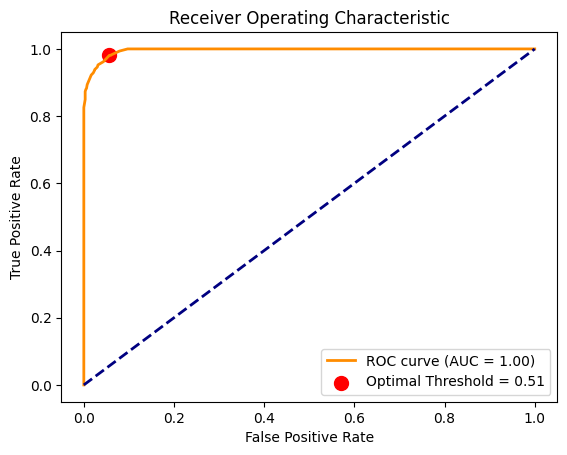

Optimal Threshold: 0.51, ROC AUC: 1.00


In [ ]:
# Optimize threshold on validation set
optimal_threshold, roc_auc = optimize_threshold(best_model, X_val, y_val)
print(f"Optimal Threshold: {optimal_threshold:.2f}, ROC AUC: {roc_auc:.2f}")

In [ ]:
# Evaluate model on validation set with optimal threshold
y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
y_pred_val = (y_pred_proba_val >= optimal_threshold).astype(int)

# Using a Classification Threshold. Evaluating on Testing Data

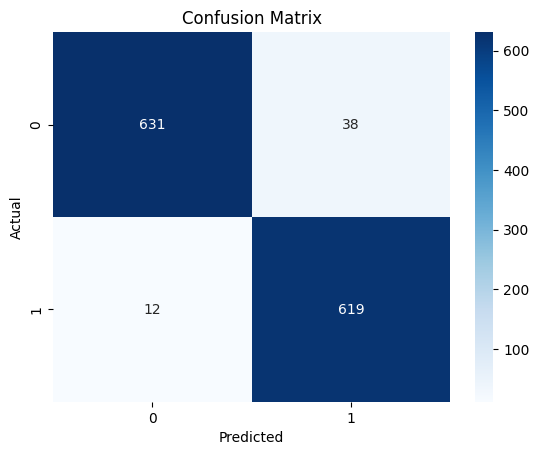

array([[631,  38],
       [ 12, 619]])

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
cm

In [ ]:
# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_val))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       669
           1       0.94      0.98      0.96       631

    accuracy                           0.96      1300
   macro avg       0.96      0.96      0.96      1300
weighted avg       0.96      0.96      0.96      1300



# **Deployment** (fitting model to full X, y set and predicting competition data)

In [ ]:
# Fit the model on the full training data
best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cap.shape', 'cap.color',
                                                   'bruises',
                                                   'stalk.color.above.ring',
                                                   'stalk.color.below.ring',
                                                   'population'])])),
                ('classifier',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(max_depth=20,
                                                                      random_state=42)),
                                              ('gb',
                                               GradientBoostingClassifier(learning_rate=0.05,
                                                                          max_depth=5,
                                                                          random_state=42))],
                                  voting='soft'))])

In [ ]:
# Predict probabilities on test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Prediction Submission

In [ ]:
# Making predictions for the competition

# Create submission DataFrame
submission_df = pd.DataFrame({
    'Id': test_ids,
    'poisonous': y_test_pred
})

# Save submission to CSV
submission_df.to_csv('mushroom_submission2.csv', index=False)
print("Submission file 'mushroom_submission2.csv' created successfully.")

Submission file 'mushroom_submission2.csv' created successfully.
